In [1]:
import intake
import allel
import numpy as np
import matplotlib.pyplot as plt
from dask_kubernetes import KubeCluster
from dask.distributed import Client
import pandas as pd
%matplotlib inline

import seaborn as sns
sns.set_context('paper')

import scipy.stats as ss

import functools
import zarr

import fsspec
import random

import dask

## Setup

In [2]:
cluster = KubeCluster(n_workers=20)
client = Client(cluster)

client

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:  tcp://10.33.119.27:36015
distributed.scheduler - INFO -   dashboard at:                     :8787
distributed.scheduler - INFO - Receive client connection: Client-5d211070-0dfa-11eb-81f3-0ab66d4d9298
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.33.119.27:36015 Dashboard: /user/jonbrenas1/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
cat = intake.open_catalog('https://malariagen.github.io/intake/gcs.yml')
cat

gcs:
  args:
    path: https://malariagen.github.io/intake/gcs.yml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata:
    version: 1


In [4]:
ag3 = cat.ag3
ag3

ag3:
  args:
    path: https://malariagen.github.io/intake/gcs/ag3.yml
  description: 'The MalariaGEN Anopheles gambiae 1000 Genomes Project phase 3 data
    resource. These data are published by the Anopheles gambiae 1000 Genomes Consortium.
    Please note that data included in these catalogs are made available prior to publication
    and subject to the Ag1000G terms of use - https://www.malariagen.net/data/terms-use/ag1000g-terms-use.

    '
  driver: intake.catalog.local.YAMLFileCatalog
  metadata:
    catalog_dir: https://malariagen.github.io/intake


In [5]:
df_sets = ag3.sample_sets.read()
df_sets

/opt/conda/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
distributed.scheduler - INFO - Register tcp://10.33.123.18:42951
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.123.18:42951
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.120.32:33581
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.120.32:33581
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.121.17:40361
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.121.17:40361
distributed.core - INFO - Starting established connection


,sample_set,sample_count
0,AG1000G-AO,81
1,AG1000G-BF-A,181
2,AG1000G-BF-B,102
3,AG1000G-BF-C,13
4,AG1000G-CD,76
5,AG1000G-CF,73
6,AG1000G-CI,80
7,AG1000G-CM-A,303
8,AG1000G-CM-B,97
9,AG1000G-CM-C,44


In [6]:
for s in df_sets['sample_set'][:-1]:
    print(s)
    df_species = cat.ag3.species_calls_20200422_aim(sample_set=s).read()
    # call species - just use AIMs, should be fine
    #df_species.species_gambcolu_arabiensis.replace({'intermediate': 'intermediate_gambcolu_arabiensis'}, inplace=True)
    #df_species.species_gambiae_coluzzii.replace({'intermediate': 'intermediate_gambiae_coluzzii'}, inplace=True)
    df_species['species'] = df_species.species_gambcolu_arabiensis.copy()
    loc_gamb_colu = df_species.species_gambcolu_arabiensis == 'gamb_colu'
    df_species.loc[loc_gamb_colu, 'species'] = df_species.species_gambiae_coluzzii[loc_gamb_colu]
    print(df_species.groupby('species').size())

AG1000G-AO
species
coluzzii    81
dtype: int64
AG1000G-BF-A
species
coluzzii        82
gambiae         98
intermediate     1
dtype: int64
AG1000G-BF-B
species
arabiensis     3
coluzzii      53
gambiae       46
dtype: int64
AG1000G-BF-C
species
gambiae    13
dtype: int64
AG1000G-CD
species
gambiae    76
dtype: int64
AG1000G-CF
species
coluzzii    18
gambiae     55
dtype: int64
AG1000G-CI
species
coluzzii    80
dtype: int64
AG1000G-CM-A
species
gambiae    303
dtype: int64
AG1000G-CM-B
species
coluzzii     7
gambiae     90
dtype: int64
AG1000G-CM-C
species
arabiensis     2
coluzzii      19
gambiae       23
dtype: int64
AG1000G-FR
species
gambiae    23
dtype: int64
AG1000G-GA-A
species
gambiae    69
dtype: int64
AG1000G-GH
species
coluzzii    64
gambiae     36
dtype: int64
AG1000G-GM-A
species
coluzzii         5
gambiae         58
intermediate    11
dtype: int64
AG1000G-GM-B
species
coluzzii        16
gambiae          9
intermediate     6
dtype: int64
AG1000G-GM-C
species
coluzzii        1

In [7]:
wt_store = zarr.DirectoryStore('Watt-Theta.zarr')
results = zarr.group(store=wt_store)

## Functions

In [8]:
@functools.lru_cache(maxsize=None)
def load_mask(seq_id, data_set, max_miss=.1):
#     print('load_mask', seq_id)
    # site filters
    filter_pass = cat.ag3.site_filters_dt_20200416_gamb_colu.to_zarr()[seq_id]['variants']['filter_pass'][:]
    
    # missingness
    gt = allel.GenotypeDaskArray(cat.ag3.snp_genotypes(sample_set=data_set).to_zarr()[seq_id]['calldata']['GT'])
    n_miss = gt.count_missing(axis=1).compute()
    n_samples = gt.shape[1]
    low_miss = (n_miss / n_samples) < max_miss
    
    # combine
    mask = filter_pass & low_miss
    
    return mask

@functools.lru_cache(maxsize=None)
def load_pos(seq_id):
#     print('load_pos', seq_id)
    pos = allel.SortedIndex(cat.ag3.snp_sites.to_zarr()[seq_id]['variants']['POS'])
    return pos

@functools.lru_cache(maxsize=None)
def get_region(region, data_set, max_miss=.1):
    
    # unpack region
    seq_id, region_start, region_stop = region
    
    # setup variables
    gt = allel.GenotypeDaskArray(cat.ag3.snp_genotypes(sample_set=data_set).to_zarr()[seq_id]['calldata']['GT'])
    pos = load_pos(seq_id)
    
    # apply mask
    mask = load_mask(seq_id, data_set, max_miss)
    pos_mask = pos[mask]
    gt_mask = gt[mask]
    
    # restrict to genome region
    loc_region = pos_mask.locate_range(region_start, region_stop)
    pos_region = pos_mask[loc_region]
    mask_region = mask[loc_region]
    gt_region = gt_mask[loc_region]
        
    return mask_region, pos_region, gt_region

In [9]:
#@functools.lru_cache(maxsize=None)
def count_alleles_rdm(gt_region, pop_ids, downsample_size = 0):
    
    if downsample_size > 0:
        pop_ids = np.sort(random.sample(list(pop_ids), downsample_size))
    
    gt_pop = gt_region.take(pop_ids, axis=1)
    
    # perform allele count
    ac = gt_pop.count_alleles(max_allele=3).compute()
    
    return ac

In [10]:
@functools.lru_cache(maxsize=None)
def get_masks_and_windows(dataset):
    mask_3L, pos_masked_3L, gt_3L = get_region(region_3L_free, dataset)
    mask_3R, pos_masked_3R, gt_3R = get_region(region_3R_free, dataset)

    all_mask_3L = load_mask('3L', dataset, .1)
    all_mask_3R = load_mask('3R', dataset, .1)

    is_accessible_3L = np.zeros(seq_len_3L, dtype=bool)
    is_accessible_3L[pos_3L - 1] = all_mask_3L
    is_accessible_3R = np.zeros(seq_len_3R, dtype=bool)
    is_accessible_3R[pos_3R - 1] = all_mask_3R

    windows_euchromatin_3L = allel.equally_accessible_windows(
        is_accessible_3L, 
        size=50_000, 
        start=1_000_000,
        stop=37_000_000
    )
    windows_euchromatin_3R = allel.equally_accessible_windows(
        is_accessible_3R, 
        size=50_000, 
        start=15_000_000,
        stop=41_000_000
    )
    return {
        'mask': {
            '3L': mask_3L,
            '3R': mask_3R
        },
        'pos_masked': {
            '3L': pos_masked_3L,
            '3R': pos_masked_3R
        },
        'gt': {
            '3L': gt_3L,
            '3R': gt_3R
        },
        'all_mask': {
            '3L': all_mask_3L,
            '3R': all_mask_3R
        },
        'is_accessible': {
            '3L': is_accessible_3L,
            '3R': is_accessible_3R
        },
        'windows_euchromatin': {
            '3L': windows_euchromatin_3L,
            '3R': windows_euchromatin_3R
        }
    }

In [11]:
def get_idxs_query(dataset, species = None, location = None, year = None):
    samples = cat.ag3.samples(sample_set=dataset).read()
    
    calls = cat.ag3.species_calls_20200422_aim(sample_set=dataset).read()
    # call species - just use AIMs, should be fine
    calls.species_gambcolu_arabiensis.replace({'intermediate': 'intermediate_gambcolu_arabiensis'}, inplace=True)
    calls.species_gambiae_coluzzii.replace({'intermediate': 'intermediate_gambiae_coluzzii'}, inplace=True)
    calls['species'] = calls.species_gambcolu_arabiensis.copy()
    loc_gc = calls.species_gambcolu_arabiensis == 'gamb_colu'
    calls.loc[loc_gc, 'species'] = calls.species_gambiae_coluzzii[loc_gc]
    
    meta = samples.merge(calls, on='sample_id', how='left', sort=False)
    
    query = dataset
    loc =  (
            (meta.species != '')
    )
    
    if species:
        loc = loc & ( (meta.species == species) )
        query = query + "_" + species
        
    if location:
        loc  = loc & ( (meta.location == location) )
        query = query + "_" + location

 
    if year:
        loc = loc & ( (meta.year == int(year)) )
        query = query + "_" + year
    
    idxs = meta[loc].index.values
    
    return idxs, query

In [12]:
def compute_wat(query, sample_size, it, m_w, idxs):
    result_path = f'{query}_{sample_size}_{it}'
    
    if result_path in results:
        # load previously computed array into memory
        wat = results[result_path][:]
        return wat
    
    else:
        # run the computation to compute wat - N.B., wat should be a numpy array
        ac_3L = count_alleles_rdm(m_w['gt']['3L'], idxs, downsample_size = sample_size)
        ac_3R = count_alleles_rdm(m_w['gt']['3R'], idxs, downsample_size = sample_size)
        wat_euchromatin_3L, _, _, _ = allel.windowed_watterson_theta(
            pos=m_w['pos_masked']['3L'], 
            ac=ac_3L, 
            windows=m_w['windows_euchromatin']['3L'], 
            is_accessible=m_w['is_accessible']['3L']
            )
        wat_euchromatin_3R, _, _, _ = allel.windowed_watterson_theta(
            pos=m_w['pos_masked']['3R'], 
            ac=ac_3R, 
            windows=m_w['windows_euchromatin']['3R'], 
            is_accessible=m_w['is_accessible']['3R']
            )
        wat = np.concatenate((wat_euchromatin_3L, wat_euchromatin_3R))
        
        # store results, assuming wat is a numpy array
        results.create_dataset(result_path, data=wat)
        
        return wat

In [13]:
def plot_wat(dataset, species = None, location = None, year=None, start_value = 10, inc = 5, n_it = 5, end_value = None):
    m_w = get_masks_and_windows(dataset)
    idxs, pop_query = get_idxs_query(dataset, species, location, year)
    wat_list = []
    dps_list = []
    if not end_value:
        end_value = len(idxs)
    for sample_size in range(start_value, end_value, inc):
        for iteration in range(n_it):
            wat = compute_wat(pop_query, sample_size, iteration, m_w, idxs)
            wat_list.append(wat)
            dps_list.append(sample_size)
    return wat_list, dps_list

## Regions

In [14]:
# reference genome
genome = zarr.open_consolidated(
    store=fsspec.get_mapper(
        'gs://vo_agam_release/reference/genome/agamp4/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.zarr'
    )
)
list(genome)

['2L', '2R', '3L', '3R', 'Mt', 'UNKN', 'X', 'Y_unplaced']

In [15]:
seq_len_3R = len(genome['3R'])
seq_len_3L = len(genome['3L'])

In [16]:
region_3L_free = '3L', 15_000_000, 41_000_000
region_3R_free = '3R', 1_000_000, 37_000_000

In [17]:
pos_3R = load_pos('3R')
pos_3L = load_pos('3L')

## Dataframes

In [18]:
df_gambiae = pd.read_csv('Watt-Theta-gambiae.csv')
df_coluzzii = pd.read_csv('Watt-Theta-coluzzii.csv')

## Gambiae

### Burkina Faso A

In [36]:
dataset = 'AG1000G-BF-A'

In [37]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae')

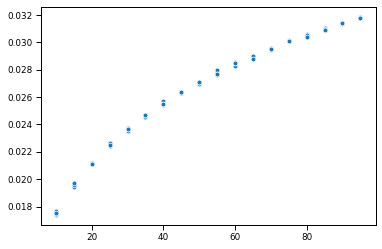

In [38]:
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

In [39]:
df_gambiae = pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['BF-A'] * len(dps_list)})

In [40]:
df_gambiae.to_csv('Watt-Theta-gambiae.csv')

### Burkina Faso B

In [ ]:
dataset = 'AG1000G-BF-B'

In [ ]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

In [ ]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['BF-B'] * len(dps_list)}))

In [ ]:
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

### Burkina Faso C

In [ ]:
dataset = 'AG1000G-BF-C'

In [ ]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae', start_value=5, inc=1)
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

In [ ]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['BF-C'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

### Democratic Republic of Congo

In [ ]:
dataset = 'AG1000G-CD'

In [ ]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

In [ ]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['CD'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

## Central African Republic

In [ ]:
dataset = 'AG1000G-CF'

In [ ]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

In [ ]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['CF'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

## Cameroon A

In [ ]:
dataset = 'AG1000G-CM-A'

In [ ]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae', inc=20)
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

In [ ]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['CM-A'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

## Cameroon B

In [ ]:
dataset = 'AG1000G-CM-B'

In [ ]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

In [ ]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['CM-B'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

## Cameroon C

In [ ]:
dataset = 'AG1000G-CM-C'

In [ ]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae', inc = 2)
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

In [ ]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['CM-C'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

## Mayotte 

In [41]:
dataset = 'AG1000G-FR'

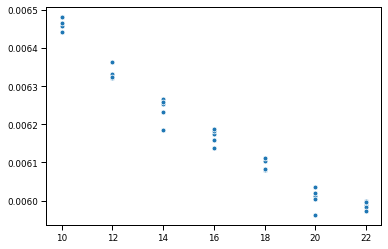

In [42]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae', inc = 2)
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

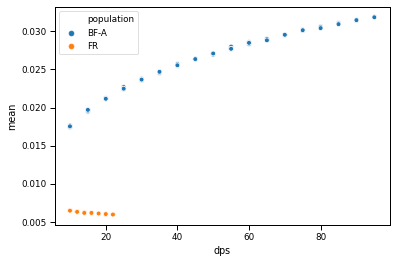

In [43]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['FR'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

In [44]:
df_gambiae.to_csv('Watt-Theta-gambiae.csv')

## Gabon

In [45]:
dataset = 'AG1000G-GA-A'

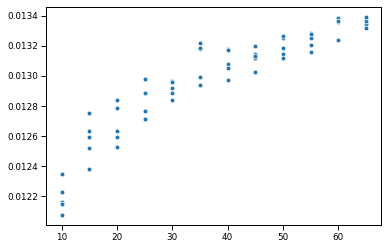

In [46]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

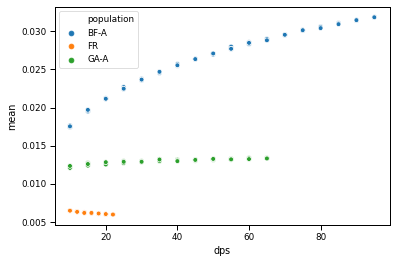

In [47]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['GA-A'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

In [48]:
df_gambiae.to_csv('Watt-Theta-gambiae.csv')

## Ghana

In [ ]:
dataset = 'AG1000G-GH'

In [ ]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae', inc=2)
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

In [ ]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['GH'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

## The Gambia A

In [49]:
dataset = 'AG1000G-GM-A'

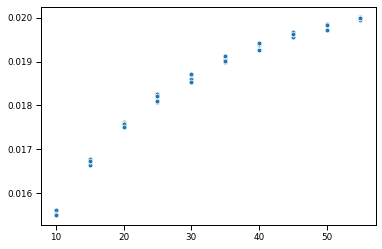

In [50]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

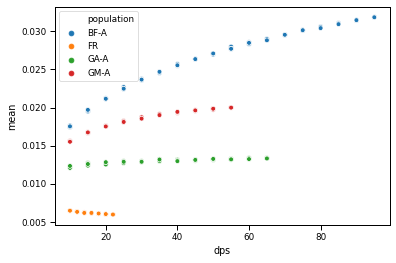

In [51]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['GM-A'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

In [52]:
df_gambiae.to_csv('Watt-Theta-gambiae.csv')

## The Gambia B

In [ ]:
dataset = 'AG1000G-GM-B'

In [ ]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae', start_value=5, inc=1)
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

In [ ]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['GM-B'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

## Guinea A

In [ ]:
dataset = 'AG1000G-GN-A'

In [ ]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

In [ ]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['GN-A'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

## Guinea B

In [53]:
dataset = 'AG1000G-GN-B'

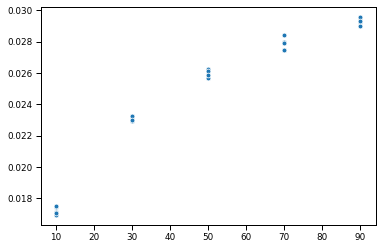

In [54]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae', inc = 20, end_value = 100)
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

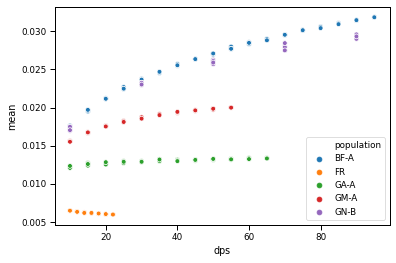

In [55]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['GN-B'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

In [56]:
df_gambiae.to_csv('Watt-Theta-gambiae.csv')

## Guinea Bissau

In [ ]:
dataset = 'AG1000G-GW'

In [ ]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

In [ ]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['GW'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

## Kenya

In [57]:
dataset = 'AG1000G-KE'

In [ ]:
df_samples = cat.ag3.samples(sample_set=dataset).read()
df_samples.groupby('year').size()

In [ ]:
df_species = cat.ag3.species_calls_20200422_aim(sample_set=dataset).read()
df_species.species_gambcolu_arabiensis.replace({'intermediate': 'intermediate_gambcolu_arabiensis'}, inplace=True)
df_species.species_gambiae_coluzzii.replace({'intermediate': 'intermediate_gambiae_coluzzii'}, inplace=True)
df_species['species'] = df_species.species_gambcolu_arabiensis.copy()
loc_gamb_colu = df_species.species_gambcolu_arabiensis == 'gamb_colu'
df_species.loc[loc_gamb_colu, 'species'] = df_species.species_gambiae_coluzzii[loc_gamb_colu]
df_meta = df_samples.merge(df_species, on='sample_id', how='left', sort=False)
df_meta.groupby(['year','species']).size()

In [ ]:
df_species

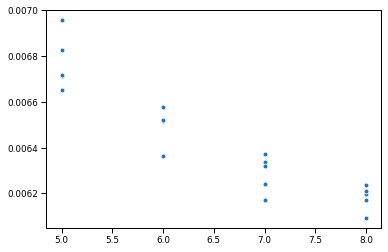

In [38]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae', year = '2012', start_value = 5, inc = 1)
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

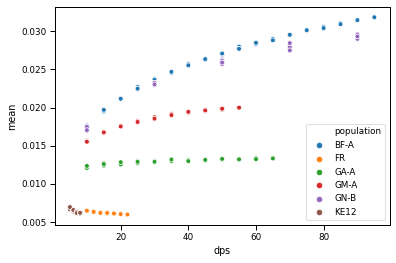

In [39]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['KE12'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

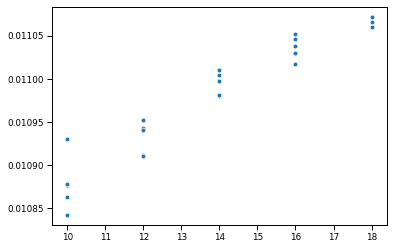

In [58]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae', year = '2000', inc = 2)
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

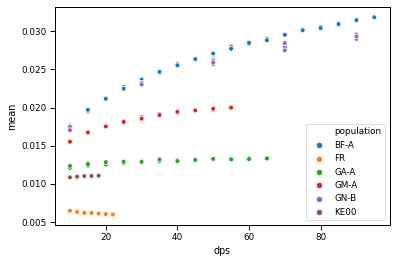

In [59]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['KE00'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

In [60]:
df_gambiae.to_csv('Watt-Theta-gambiae.csv')

In [ ]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

In [ ]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['KE'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

## Mali A

In [ ]:
dataset = 'AG1000G-ML-A'

In [ ]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae', inc = 2)
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

In [ ]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['ML-A'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

## Mali B

In [ ]:
dataset = 'AG1000G-ML-B'

In [ ]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae', inc = 2)
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

In [ ]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['ML-B'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

## Mozambique

In [61]:
dataset = 'AG1000G-MZ'

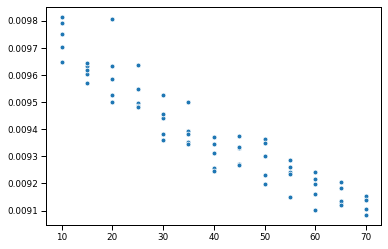

In [62]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

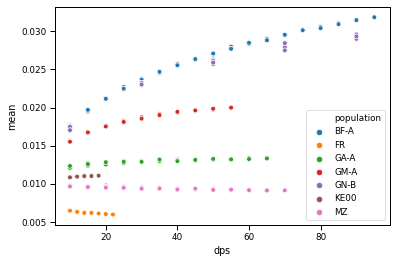

In [63]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['MZ'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

In [64]:
df_gambiae.to_csv('Watt-Theta-gambiae.csv')

## Tanzania

In [22]:
dataset = 'AG1000G-TZ'

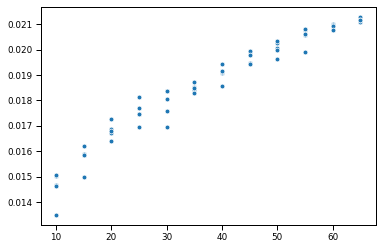

In [23]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

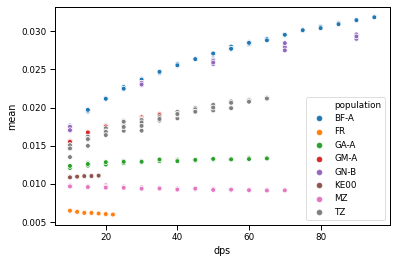

In [24]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['TZ'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

In [25]:
df_gambiae.to_csv('Watt-Theta-gambiae.csv')

## Uganda

In [26]:
dataset = 'AG1000G-UG'

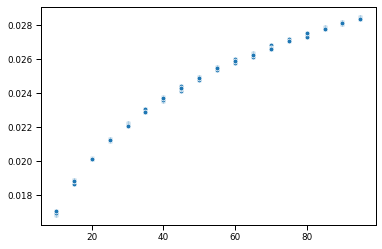

In [27]:
wat_list, dps_list = plot_wat(dataset, species = 'gambiae', end_value=100)
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

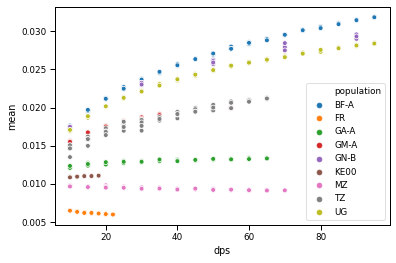

In [28]:
df_gambiae = df_gambiae.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['UG'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_gambiae)

In [29]:
df_gambiae.to_csv('Watt-Theta-gambiae.csv')

distributed.utils_perf - INFO - full garbage collection released 64.80 MB from 727 reference cycles (threshold: 10.00 MB)
distributed.scheduler - INFO - Remove worker tcp://10.33.127.13:39115
distributed.core - INFO - Removing comms to tcp://10.33.127.13:39115
distributed.scheduler - INFO - Register tcp://10.33.134.2:39253
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.134.2:39253
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.0.2:45403
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.0.2:45403
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.2.2:36971
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.2.2:36971
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.5.2:39465
distributed.scheduler - INFO - Starting worker compute str

## Coluzzii

### Angola

In [24]:
dataset = 'AG1000G-AO'

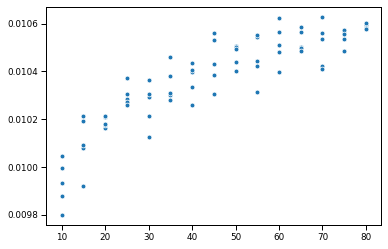

In [25]:
wat_list, dps_list = plot_wat(dataset, species = 'coluzzii')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

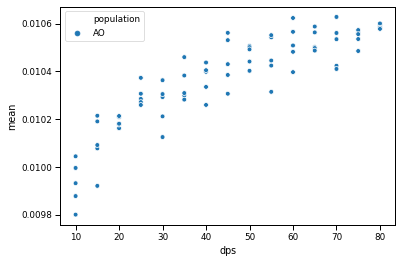

In [26]:
df_coluzzii = pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['AO'] * len(dps_list)})
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_coluzzii)

In [27]:
df_coluzzii.to_csv('Watt-Theta-coluzzii.csv')

### Burkina Faso A

In [28]:
dataset = 'AG1000G-BF-A'

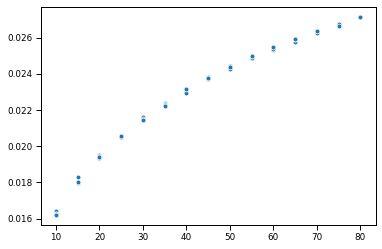

In [29]:
wat_list, dps_list = plot_wat(dataset, species = 'coluzzii')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

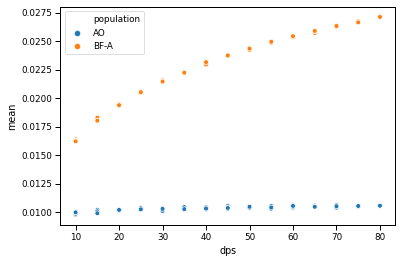

In [30]:
df_coluzzii = df_coluzzii.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['BF-A'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_coluzzii)

In [31]:
df_coluzzii.to_csv('Watt-Theta-coluzzii.csv')

### Burkina Faso B

In [32]:
dataset = 'AG1000G-BF-B'

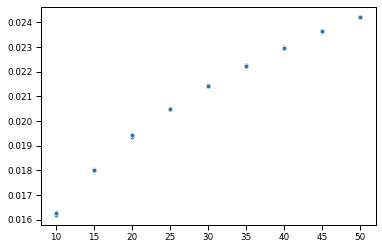

In [33]:
wat_list, dps_list = plot_wat(dataset, species = 'coluzzii')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

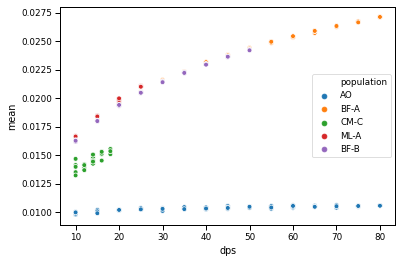

In [34]:
df_coluzzii = df_coluzzii.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['BF-B'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_coluzzii)

In [35]:
df_coluzzii.to_csv('Watt-Theta-coluzzii.csv')

### Central African Republic

In [36]:
dataset = 'AG1000G-CF'

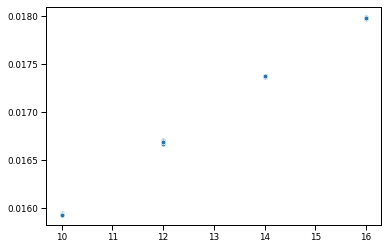

In [37]:
wat_list, dps_list = plot_wat(dataset, species = 'coluzzii', inc=2)
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

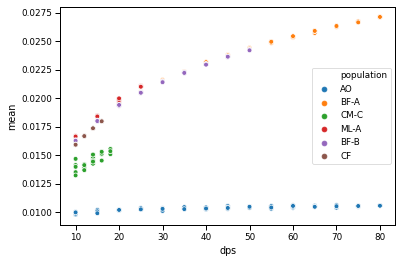

In [38]:
df_coluzzii = df_coluzzii.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['CF'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_coluzzii)

In [39]:
df_coluzzii.to_csv('Watt-Theta-coluzzii.csv')

### Cote d'Ivoire

In [40]:
dataset = 'AG1000G-CI'

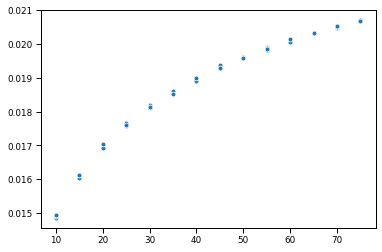

In [41]:
wat_list, dps_list = plot_wat(dataset, species = 'coluzzii')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

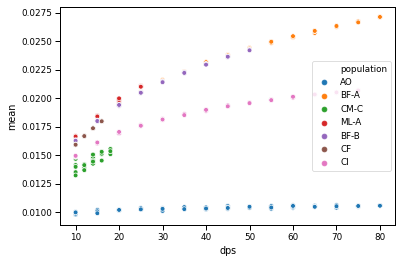

In [42]:
df_coluzzii = df_coluzzii.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['CI'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_coluzzii)

In [43]:
df_coluzzii.to_csv('Watt-Theta-coluzzii.csv')

### Cameroon C

In [21]:
dataset = 'AG1000G-CM-C'

In [27]:
df_samples = cat.ag3.samples(sample_set=dataset).read()
df_species = cat.ag3.species_calls_20200422_aim(sample_set=dataset).read()
df_species.species_gambcolu_arabiensis.replace({'intermediate': 'intermediate_gambcolu_arabiensis'}, inplace=True)
df_species.species_gambiae_coluzzii.replace({'intermediate': 'intermediate_gambiae_coluzzii'}, inplace=True)
df_species['species'] = df_species.species_gambcolu_arabiensis.copy()
loc_gamb_colu = df_species.species_gambcolu_arabiensis == 'gamb_colu'
df_species.loc[loc_gamb_colu, 'species'] = df_species.species_gambiae_coluzzii[loc_gamb_colu]
df_meta = df_samples.merge(df_species, on='sample_id', how='left', sort=False)
df_meta[df_meta.species == 'coluzzii'].groupby('location').size()

location
Campo        2
Douala       2
Lagdo        1
Nkolondom    5
Tibati       2
Yaounde      7
dtype: int64

distributed.scheduler - INFO - Remove worker tcp://10.32.65.2:38255
distributed.core - INFO - Removing comms to tcp://10.32.65.2:38255


distributed.scheduler - INFO - Register tcp://10.32.61.2:41663
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.61.2:41663
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.62.2:42827
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.62.2:42827
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.63.2:38875
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.63.2:38875
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.64.2:42569
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.64.2:42569
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.73.2:43641
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.73.2:43641
distributed.core - INFO

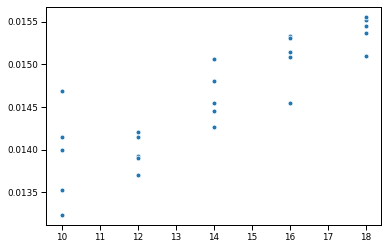

In [22]:
wat_list, dps_list = plot_wat(dataset, species = 'coluzzii', inc =2)
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

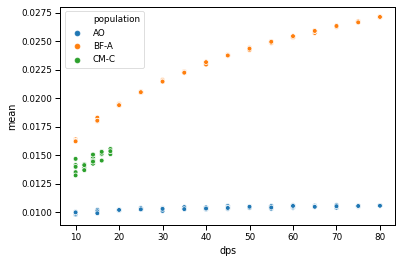

In [23]:
df_coluzzii = df_coluzzii.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['CM-C'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_coluzzii)

### Ghana

In [19]:
dataset = 'AG1000G-GH'

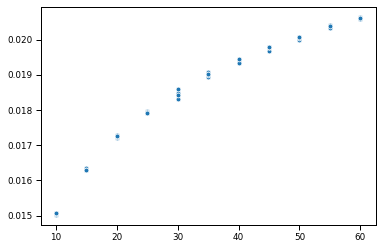

In [20]:
wat_list, dps_list = plot_wat(dataset, species = 'coluzzii')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

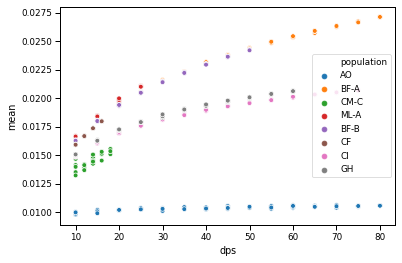

In [21]:
df_coluzzii = df_coluzzii.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['GH'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_coluzzii)

In [22]:
df_coluzzii.to_csv('Watt-Theta-coluzzii.csv')

distributed.scheduler - INFO - Register tcp://10.32.95.2:42273
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.95.2:42273
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.108.2:44883
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.108.2:44883
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.96.2:34245
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.96.2:34245
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.109.2:44685
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.109.2:44685
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.97.2:33731
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.97.2:33731
distributed.core - 

### Gambia B

In [23]:
dataset = 'AG1000G-GM-B'

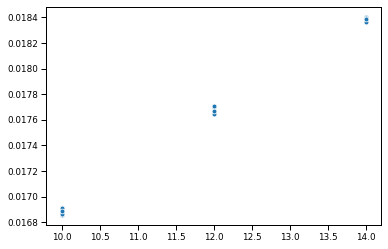

In [24]:
wat_list, dps_list = plot_wat(dataset, species = 'coluzzii', inc=2)
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

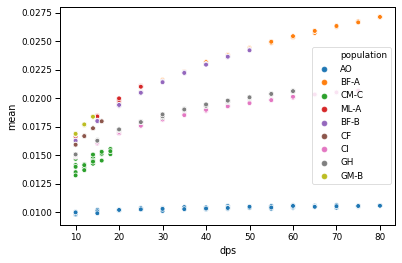

In [25]:
df_coluzzii = df_coluzzii.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['GM-B'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_coluzzii)

In [26]:
df_coluzzii.to_csv('Watt-Theta-coluzzii.csv')

### Gambia C

In [27]:
dataset = 'AG1000G-GM-C'

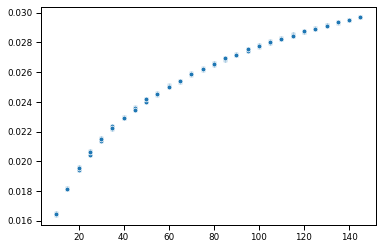

In [28]:
wat_list, dps_list = plot_wat(dataset, species = 'coluzzii')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

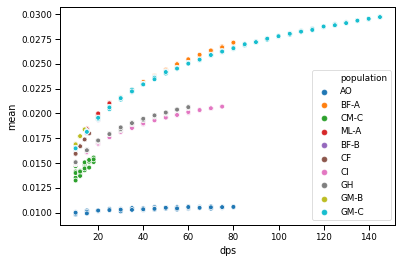

In [29]:
df_coluzzii = df_coluzzii.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['GM-C'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_coluzzii)

In [30]:
df_coluzzii.to_csv('Watt-Theta-coluzzii.csv')

### Guinea B

In [31]:
dataset = 'AG1000G-GN-B'

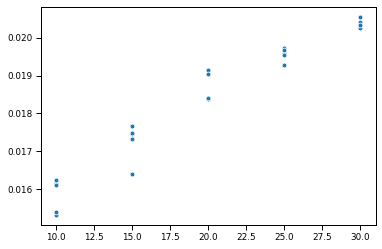

In [32]:
wat_list, dps_list = plot_wat(dataset, species = 'coluzzii')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

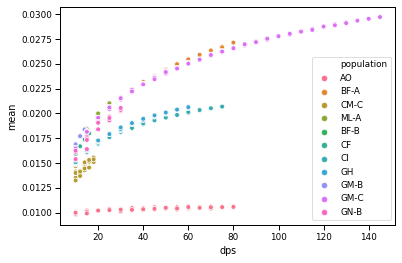

In [33]:
df_coluzzii = df_coluzzii.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['GN-B'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_coluzzii)

In [34]:
df_coluzzii.to_csv('Watt-Theta-coluzzii.csv')

### Mali A

In [28]:
dataset = 'AG1000G-ML-A'

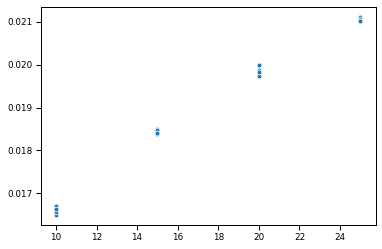

In [29]:
wat_list, dps_list = plot_wat(dataset, species = 'coluzzii')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

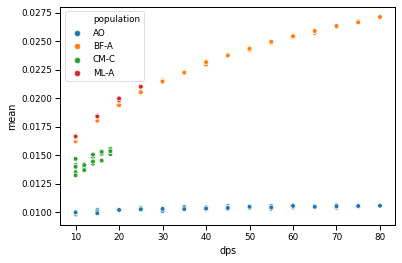

In [30]:
df_coluzzii = df_coluzzii.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['ML-A'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_coluzzii)

In [31]:
df_coluzzii.to_csv('Watt-Theta-coluzzii.csv')

distributed.scheduler - INFO - Remove worker tcp://10.32.72.2:39751
distributed.core - INFO - Removing comms to tcp://10.32.72.2:39751
distributed.scheduler - INFO - Remove worker tcp://10.32.78.2:44135
distributed.core - INFO - Removing comms to tcp://10.32.78.2:44135
distributed.scheduler - INFO - Remove worker tcp://10.32.79.2:42995
distributed.core - INFO - Removing comms to tcp://10.32.79.2:42995
distributed.scheduler - INFO - Remove worker tcp://10.32.71.2:39659
distributed.core - INFO - Removing comms to tcp://10.32.71.2:39659
distributed.scheduler - INFO - Remove worker tcp://10.32.69.2:46361
distributed.core - INFO - Removing comms to tcp://10.32.69.2:46361
distributed.scheduler - INFO - Remove worker tcp://10.32.77.2:45375
distributed.core - INFO - Removing comms to tcp://10.32.77.2:45375
distributed.scheduler - INFO - Remove worker tcp://10.32.63.2:38875
distributed.core - INFO - Removing comms to tcp://10.32.63.2:38875
distributed.scheduler - INFO - Remove worker tcp://10.3

### Mali B

In [35]:
dataset = 'AG1000G-ML-B'

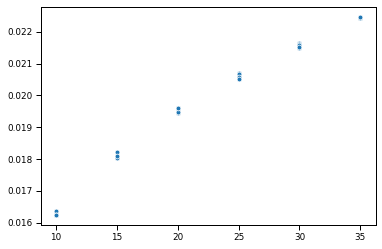

In [36]:
wat_list, dps_list = plot_wat(dataset, species = 'coluzzii')
sns.scatterplot(dps_list,[np.mean(wat) for wat in wat_list])

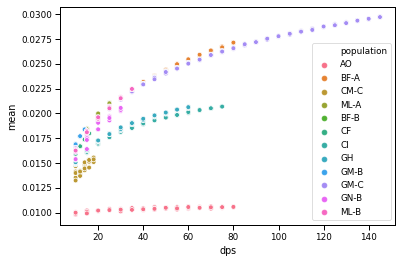

In [37]:
df_coluzzii = df_coluzzii.append(pd.DataFrame(data={'dps': dps_list, 'mean': [np.mean(wat) for wat in wat_list], 'population': ['ML-B'] * len(dps_list)}))
sns.scatterplot(x = 'dps', y = 'mean', hue = 'population', data=df_coluzzii)

In [38]:
df_coluzzii.to_csv('Watt-Theta-coluzzii.csv')